# Aplicando técnicas de Transfer Learning para autoencoders

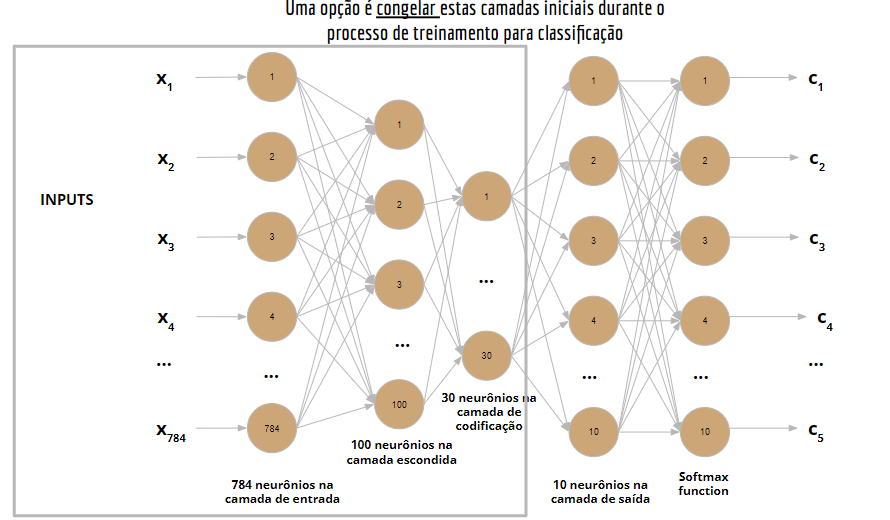

Neste exemplo, vamos construir um autoencoder simples a partir do dataset MNIST. Este dataset é bastante conhecido de vocês contendo imagem de 28x28 pixels que representam dígitos escritos a mão.

**Objetivo:** treinar primeiro o autoencoder de forma **não supervisionada** e, posteriormente, retreinar a rede aproveitando somente as camadas inicias da rede (encoder). 

In [ ]:
# Reprodutibilidade
from numpy.random import seed
import numpy as np
import tensorflow as tf

seed(1)
tf.random.set_seed(2)
np.set_printoptions(suppress=True)

### Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [ ]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
!ls

images	sample_data


### Dataset

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

### Treinamento do autoencoder utilizando os dados não anotados (unlabeled)

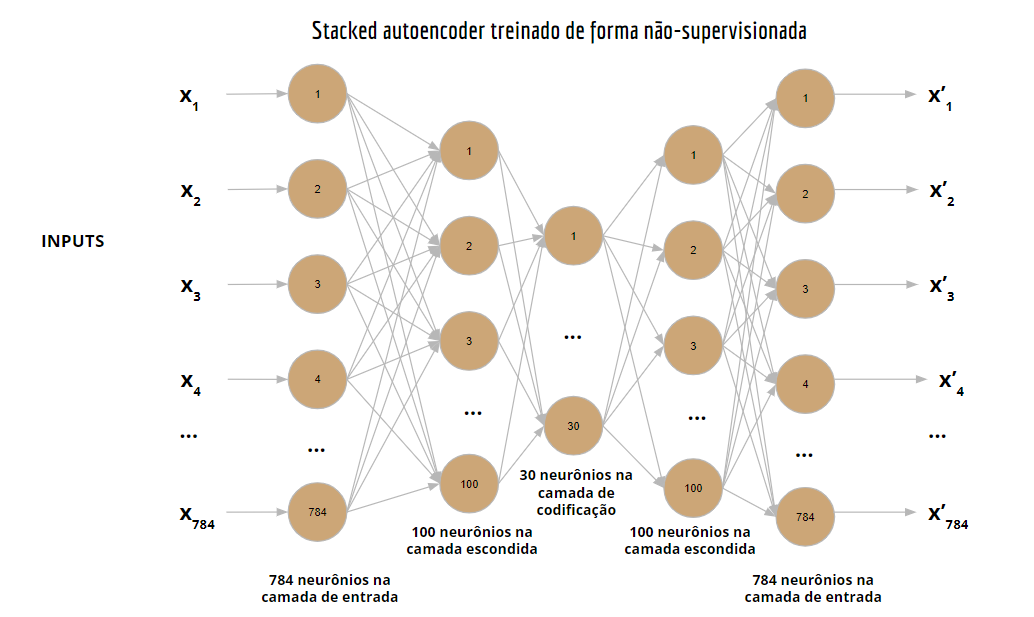

In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(60, activation="selu"),
])

stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[60]),
    keras.layers.Dense(784, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [ ]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [ ]:
stacked_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60)                84560     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            85284     
                                                                 
Total params: 169,844
Trainable params: 169,844
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1707 - rounded_accuracy: 0.9267 - val_loss: 0.1288 - val_rounded_accuracy: 0.9504
Epoch 2/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.1177 - rounded_accuracy: 0.9563 - val_loss: 0.1128 - val_rounded_accuracy: 0.9588
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1062 - rounded_accuracy: 0.9628 - val_loss: 0.1046 - val_rounded_accuracy: 0.9641
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1005 - rounded_accuracy: 0.9661 - val_loss: 0.0994 - val_rounded_accuracy: 0.9671
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0960 - rounded_accuracy: 0.9688 - val_loss: 0.0956 - val_rounded_accuracy: 0.9693
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0932 - rounded_accuracy: 0.9705 - val_loss: 0.0929 - val_rounded_accuracy: 0.9709
Epoch 7/20
1719/1719 [================

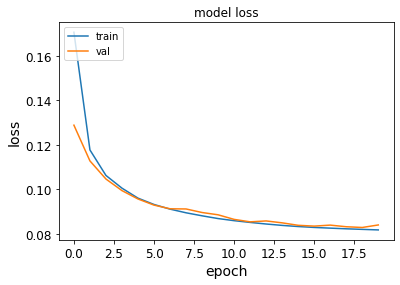

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Visualizando os resultados do autoencoder

Antes de seguirmos para a etapa de treinamento supervisionado, vamos visualizar o resultado da reconstrução das imagens. Até este momento, treinamos um autoencoder de forma não supervisionada. Em outras palavras, não utilizamos os labels para treinamento do modelo.

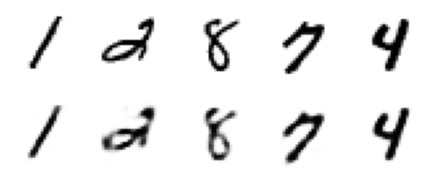

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

In [ ]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


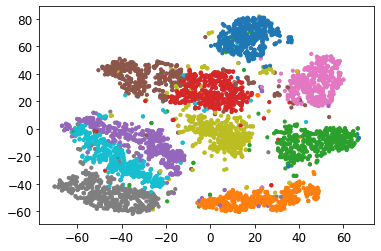

In [ ]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")


### Treinamento supervisionado - Reutilize as camadas do encoder para criar uma nova rede neural

Nesta etapa, as camadas do encoder serão utilizadas para construção de uma nova rede. Essa nova rede terá a sua saída modificada para executar a classificação dos dígitos.


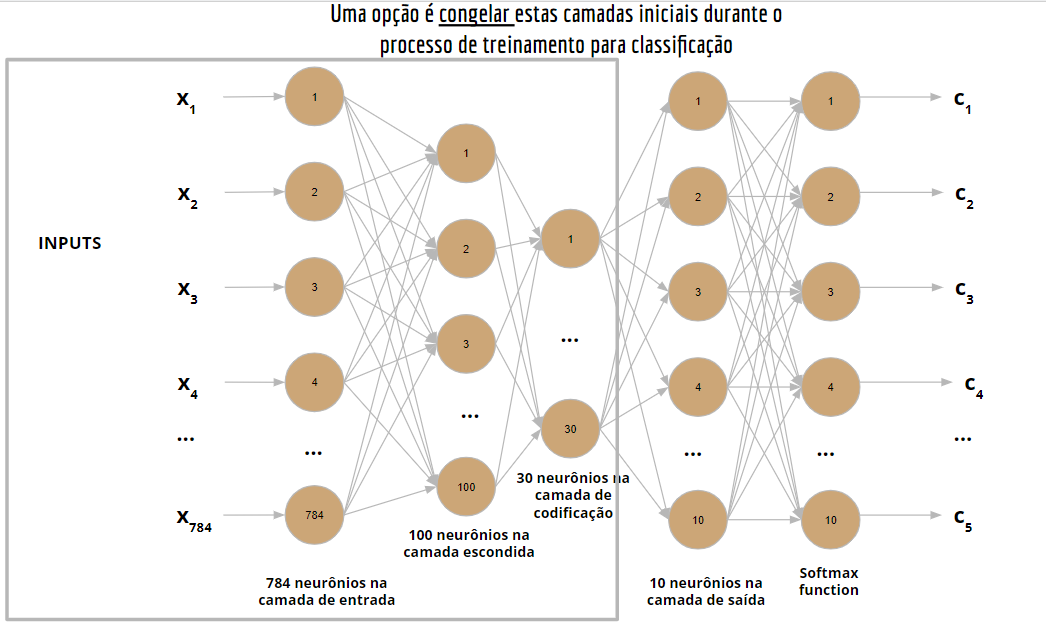

In [ ]:
class_layer = keras.models.Sequential([
    keras.layers.Dense(10, activation="softmax", input_shape=[60])
])

class_model = keras.models.Sequential([stacked_encoder, class_layer])

Uma possibilidade, nos casos onde o volume de dados anotados é muito pequeno você pode *congelar* os pesos das camadas do encoder. Isso significa que durante o processo de treinamento estes pesos não serão modificados. 

Isso é feito definindo para `False` o atributo `trainable` que todas as camadas de rede tem no Keras.

In [ ]:
class_model.layers[0].trainable = False

In [ ]:
class_model.compile(loss='categorical_crossentropy',
                   optimizer='adam', metrics=[rounded_accuracy])

Veja no exemplo abaixo que somente os **310 pesos** da camada de saída permanecem como ajustáveis ao longo do treinamento. Os 81.530 pesos da camada de encoder não serão alterados.

In [ ]:
class_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60)                84560     
                                                                 
 sequential_3 (Sequential)   (None, 10)                610       
                                                                 
Total params: 85,170
Trainable params: 610
Non-trainable params: 84,560
_________________________________________________________________


### Treine esta rede em dados anotados para uma determinada tarefa de classificação. Esta etapa irá precisar de bem menos dados anotados do que o treinamento de um modelo do zero para performar essa mesma tarefa

In [ ]:
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
history = class_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=2)

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.1345 - rounded_accuracy: 0.9447 - val_loss: 0.3466 - val_rounded_accuracy: 0.9813
Epoch 2/2
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3979 - rounded_accuracy: 0.9773 - val_loss: 0.2924 - val_rounded_accuracy: 0.9838


In [ ]:
class_model.predict((X_valid[:10]))

array([[0.00001411, 0.9845418 , 0.00654185, 0.00397268, 0.00031154,
        0.00045286, 0.00021877, 0.00196624, 0.0017093 , 0.00027085],
       [0.00051169, 0.00044999, 0.0083785 , 0.00359923, 0.9399977 ,
        0.01555194, 0.00362444, 0.00024553, 0.00755062, 0.0200905 ],
       [0.00021006, 0.00149681, 0.00027762, 0.00222755, 0.00093508,
        0.16103227, 0.00014122, 0.00009278, 0.83278966, 0.00079692],
       [0.0008041 , 0.00004713, 0.00003897, 0.00044836, 0.00326473,
        0.00059979, 0.00000047, 0.9630131 , 0.00013126, 0.03165212],
       [0.00000404, 0.0000073 , 0.00000136, 0.00001404, 0.97855514,
        0.00074705, 0.00001206, 0.00091565, 0.00658171, 0.01316161],
       [0.00000579, 0.00027691, 0.00772491, 0.0004817 , 0.9599303 ,
        0.00550485, 0.00274958, 0.00004297, 0.02034879, 0.00293424],
       [0.9774125 , 0.00000062, 0.001936  , 0.0005757 , 0.00000379,
        0.01689555, 0.00010088, 0.000002  , 0.00307241, 0.00000037],
       [0.01150381, 0.00000059, 0.0000437

In [ ]:
y_valid[:10]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)